In [326]:
import numpy as np
import scipy.io
import xarray as xr
import os
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Altimetry data

In [367]:
base_folder = 'data/MOOSE-Altimetry'

# Going through all the files in the folder recursively

def loading_altimetry_data(years, months):
    ds = None
    folders = [base_folder + '/' + str(year) + '/' + str(month).zfill(2) for year in years for month in months]
    for folder in folders:
        print(f'Loading data from {folder}...')
        files = os.listdir(folder)
        for file in files:
            if file.endswith('.nc'):
                try:
                    if ds is None:
                        ds = xr.open_dataset(os.path.join(folder, file))
                    else:
                        ds = xr.concat([ds, xr.open_dataset(os.path.join(folder, file))], dim='time')
                
                except Exception as e:
                    print(f'Error: {e}')
                    continue
    print('Done!')
    return ds


In [370]:
# Example : january 2018

ds = loading_altimetry_data([2018],[1])
ds

Loading data from data/MOOSE-Altimetry/2018/01...
Done!


<xarray.Dataset>
Dimensions:    (time: 31, latitude: 128, nv: 2, longitude: 344)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-23 2018-01-11 ... 2018-01-16
  * latitude   (latitude) float32 30.06 30.19 30.31 30.44 ... 45.69 45.81 45.94
  * longitude  (longitude) float32 -5.938 -5.812 -5.688 ... 36.69 36.81 36.94
  * nv         (nv) int32 0 1
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, latitude, nv) float32 30.0 30.12 30.12 ... 45.88 46.0
    lon_bnds   (time, longitude, nv) float32 -6.0 -5.875 -5.875 ... 36.88 37.0
    err        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    adt        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    ugos       (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    vgos       (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    sla        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    ugosa      (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    vgosa      (time, latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2018-01-23T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-01-23T00:00:00Z
    title:                           DT merged all satellites Mediterranean S...

/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


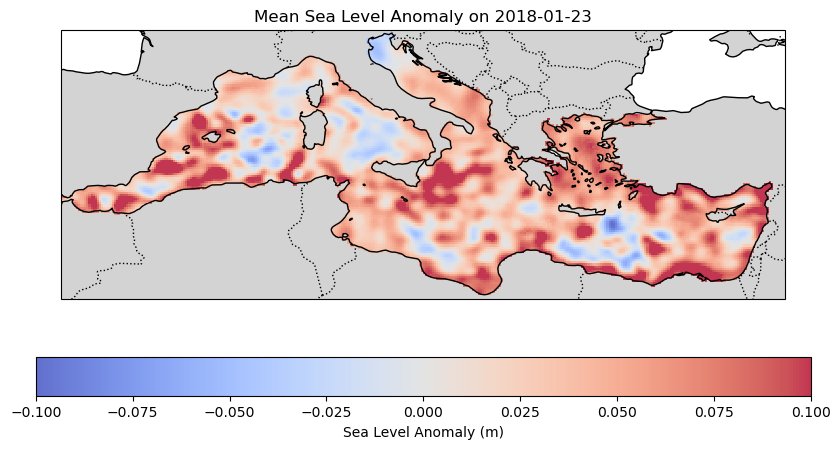

In [385]:
# Mean sea level anomaly


day = '2018-01-23'
sea_level_anomaly_map = ds['sla'].sel(time=day)
max_val = np.abs(sea_level_anomaly_map.values).max()

# Plotting the mean sea level anomaly

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
colormesh = ax.pcolormesh(
    sea_level_anomaly_map.longitude, 
    sea_level_anomaly_map.latitude, 
    sea_level_anomaly_map, 
    transform=ccrs.PlateCarree(), 
    vmin=-max_val,
    vmax=max_val,
    cmap='coolwarm',
    alpha=0.8
)
plt.colorbar(colormesh, ax=ax, orientation='horizontal', label='Sea Level Anomaly (m)')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
#ax.add_feature(cfeature.OCEAN)
plt.title(f'Mean Sea Level Anomaly on {day}')
plt.show()


##  CTD and ADCP profiles

In [307]:
base_folder = 'data/moose-cruises'

### 2021 profiles

In [361]:
file = base_folder + '/CTD2021_MOOSE_GE.mat'
data = scipy.io.loadmat(file)['all_cnv']

columns_names = data[0,:].dtype.names
colmmns_types = [type(data[0,i][0]) for i in range(len(columns_names))]

new_columns = ['idx', 'file_name', 'date', 'lat', 'lon', 'depth', 'temperature', 'salinity']
cols = [[] for i in range(len(new_columns))]

for i in range(data.shape[1]):
    idx = i
    file_name = data[0,i][0][0]
    date = data[0,i][3][0]
    lat = float(data[0,i][5][0])
    lon = float(data[0,i][6][0])
    depths = data[0,i][8][:,0]
    temperatures = data[0,i][9][:,0]
    salinities = data[0,i][10][:,0]
    for j in range(len(depths)):
        cols[0].append(idx)
        cols[1].append(file_name)
        cols[2].append(date)
        cols[3].append(lat)
        cols[4].append(lon)
        cols[5].append(depths[j])
        cols[6].append(temperatures[j])
        cols[7].append(salinities[j])

df = pd.DataFrame({new_columns[i]: cols[i] for i in range(len(new_columns))}).dropna().reset_index(drop=True)

df.head()

/var/folders/ks/hg8011s52v95t9b4pdt4llsm0000gn/T/ipykernel_29567/1332352159.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat = float(data[0,i][5][0])
/var/folders/ks/hg8011s52v95t9b4pdt4llsm0000gn/T/ipykernel_29567/1332352159.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon = float(data[0,i][6][0])


,idx,file_name,date,lat,lon,depth,temperature,salinity
0,0,moose2021_ge_leg1_001.cnv,09-Jun-2021 10:23:33,5.629333,42.951333,-1.984133,19.9878,37.9716
1,0,moose2021_ge_leg1_001.cnv,09-Jun-2021 10:23:33,5.629333,42.951333,-2.976193,20.1129,37.9698
2,0,moose2021_ge_leg1_001.cnv,09-Jun-2021 10:23:33,5.629333,42.951333,-3.968248,20.0866,37.9807
3,0,moose2021_ge_leg1_001.cnv,09-Jun-2021 10:23:33,5.629333,42.951333,-4.960297,19.9179,37.9781
4,0,moose2021_ge_leg1_001.cnv,09-Jun-2021 10:23:33,5.629333,42.951333,-5.952342,19.8021,37.9755


/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


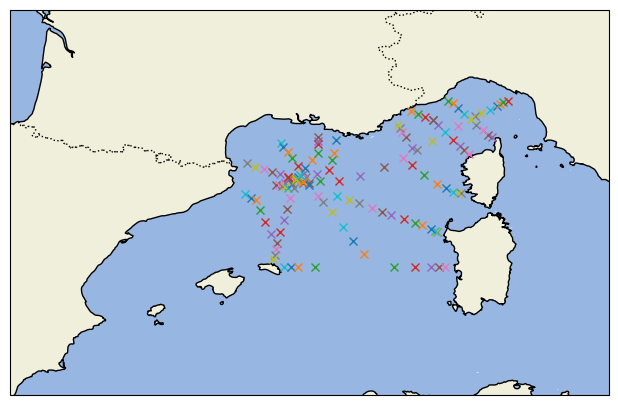

In [362]:
# Map of measurements locations
fig, ax = plt.subplots(figsize=(8,5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
for idx in df['idx'].unique():
    lat = df[df['idx'] == idx]['lat'].mean()
    lon = df[df['idx'] == idx]['lon'].mean()
    ax.plot(lat, lon, 'x')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


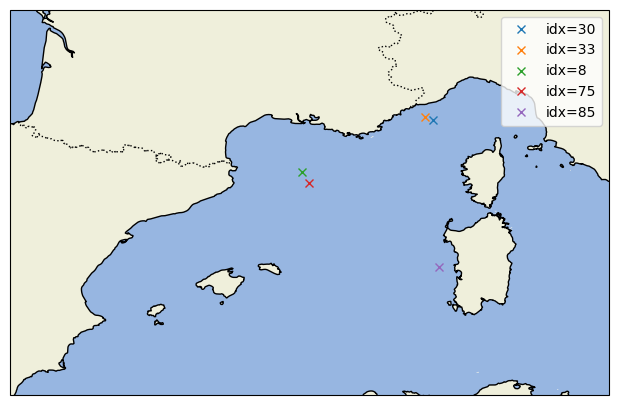

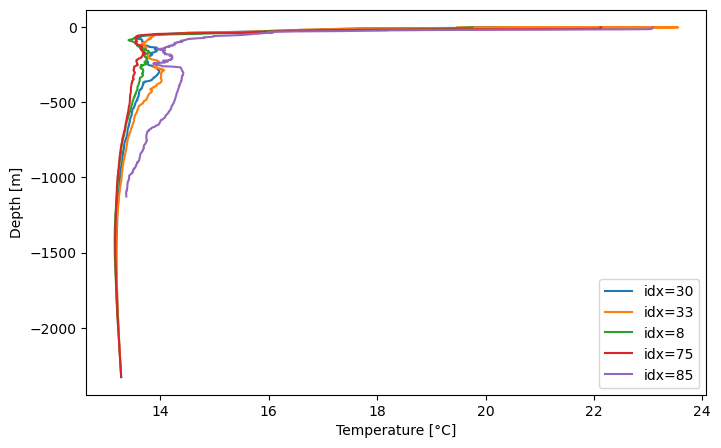

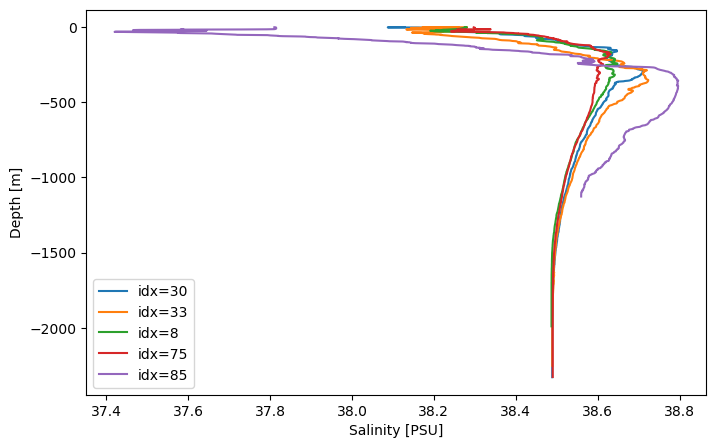

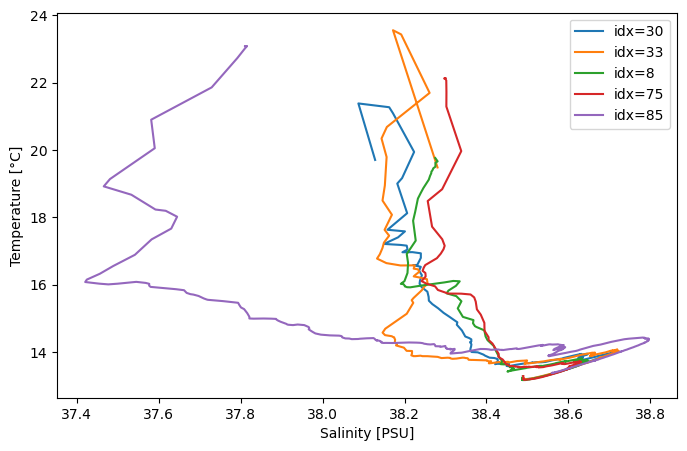

In [365]:
idxs = [np.random.choice(df['idx'].unique()) for i in range(5)]

# Map of measurements locations
fig, ax = plt.subplots(figsize=(8,5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-2, 12, 37, 46])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)
for idx in idxs:
    lat = df[df['idx'] == idx]['lat'].mean()
    lon = df[df['idx'] == idx]['lon'].mean()
    ax.plot(lat, lon, 'x', label=f'idx={idx}')
plt.legend()
plt.show()



# Temperature profiles
fig, ax = plt.subplots(figsize=(8,5))
for idx in idxs:
    df[df['idx'] == idx].plot(x='temperature', y='depth', ax=ax, label=f'idx={idx}')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Temperature [°C]')
plt.show()

# Salinity profiles
fig, ax = plt.subplots(figsize=(8,5))
for idx in idxs:
    df[df['idx'] == idx].plot(x='salinity', y='depth', ax=ax, label=f'idx={idx}')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Salinity [PSU]')
plt.show()

# TS diagram
fig, ax = plt.subplots(figsize=(8,5))
for idx in idxs:
    df[df['idx'] == idx].plot(x='salinity', y='temperature', ax=ax, label=f'idx={idx}')
ax.set_ylabel('Temperature [°C]')
ax.set_xlabel('Salinity [PSU]')
plt.show()




### Other years

In [303]:

columns_names = all_cnv[0,:].dtype.names
colmmns_types = [type(all_cnv[0,i][0]) for i in range(len(columns_names))]

cols = [[] for i in range(len(columns_names))]

for i in range(all_cnv.shape[1]):
    line = all_cnv[0,i]
    for j in range(len(columns_names)):
        x = line[j][0]
        cols[j].append(x)

df_cnv = pd.DataFrame({columns_names[i]: cols[i] for i in range(len(columns_names))})
df_cnv.head()

,filename,ptemp,salin,oxyge,fluor,sigma,temp,cond,temp1,salin1
0,moose2015_ge_leg1_001.asc,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
1,moose2015_ge_leg1_002.asc,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
2,moose2015_ge_leg1_003.asc,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
3,moose2015_ge_leg1_004.asc,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
4,moose2015_ge_leg1_005.asc,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]


In [294]:
i=1
all_cnv[0,i].dtype

dtype([('filename', 'O'), ('ptemp', 'O'), ('salin', 'O'), ('oxyge', 'O'), ('fluor', 'O'), ('sigma', 'O'), ('temp', 'O'), ('cond', 'O'), ('temp1', 'O'), ('salin1', 'O')])

In [227]:
def get_profile_df(i):
    ptemp = all_cnv[0,i][all_cnv.dtype.names.index('ptemp')][:,0]
    salin = all_cnv[0,i][all_cnv.dtype.names.index('salin')][:,0]
    temp = all_cnv[0,i][all_cnv.dtype.names.index('temp')][:,0]

    depth = np.arange(len(ptemp)) * 1.
    df = pd.DataFrame({'depth': depth, 'ptemp': ptemp, 'salin': salin, 'temp': temp})
    return df.dropna().reset_index(drop=True)

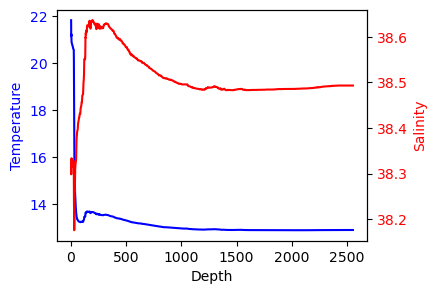

In [288]:
df = get_profile_df(np.random.randint(0, all_cnv.shape[1]))

fig, ax = plt.subplots(figsize=(4, 3)) 
ax.plot(df['depth'], df['ptemp'], color='blue')
ax.set_xlabel('Depth')
ax.set_ylabel('Temperature', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

ax2 = ax.twinx()
ax2.plot(df['depth'], df['salin'], color='red')
ax2.set_ylabel('Salinity', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()
